## **First Attempt**

In [2]:
import numpy as np
import pandas as pd


train_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/train.csv')
test_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/test.csv')

### **Index**
1\. delete_features / Age-mean / Cabin-'N' / Sex-OHE / Cabin-OHE</br>
2\. delete_features / Age-mean / Cabin-'N' / Sex-Label / Cabin-OHE</br></br>

사용할 모델 : decision tree, random forest, xgboost, lightgbm, logistic regression

**1. Age-mean / Cabin-'N' / Sex-OHE / Cabin-OHE**

In [3]:
def delete_feature(df):
    drop_list = ['PassengerId', 'Name', 'Ticket', 'Embarked']
    for drop_ele in drop_list:
        df.drop(drop_ele, axis = 1, inplace = True)
    return df

def Age_NaN1(df):
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    return df
    
def Cabin_NaN1(df):
    df['Cabin'] = df['Cabin'].fillna('N')
    return df
    
def Sex_Encoding1(df):
    from sklearn.preprocessing import OneHotEncoder
    df_sex = pd.get_dummies(df['Sex'], dummy_na = False)
    df['female'] = df_sex['female']
    df['male'] = df_sex['male']
    df.drop('Sex', axis = 1, inplace = True)
    return df
    
def Cabin_Encoding1(df):
    from sklearn.preprocessing import OneHotEncoder
    Cabin_list = df['Cabin'].values.tolist()
    for index, element in enumerate(Cabin_list):
        Cabin_list[index] = element[0]
    replace_cabin = pd.DataFrame(Cabin_list, columns = ['Cabin_encoded'])
    df_cabin = pd.get_dummies(replace_cabin, dummy_na = False)
    df2 = pd.concat([df,df_cabin], axis = 1)
    df2.drop('Cabin', axis = 1, inplace = True)
    df2
    # df2 새로운 객체를 반환하므로 함수 호출 시 train_df = Cabin_Encoding1(train_df) 사용
    return df2

In [4]:
def preprocessing(df):
    delete_feature(df)
    Age_NaN1(df)
    Cabin_NaN1(df)
    Sex_Encoding1(df)
    df2 = Cabin_Encoding1(df)
    return df2

In [5]:
from sklearn.model_selection import train_test_split
train_df = preprocessing(train_df)

Label = train_df['Survived']
Feature = train_df.drop('Survived', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(Feature, Label, test_size = 0.3, random_state = 42)

**Decision Tree**

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

seed_list = list()
for i in range(1,1001):
    dct_model = DecisionTreeClassifier(random_state = i)
    dct_model.fit(X_train, y_train)
    pred = dct_model.predict(X_test)
    seed_list.append(accuracy_score(y_test, pred))

seed = seed_list.index(max(seed_list)) + 1

print("가장 좋은 성능을 보여주는 seed : ", seed)


가장 좋은 성능을 보여주는 seed :  51


In [14]:
from sklearn.metrics import accuracy_score

dct_model = DecisionTreeClassifier(random_state = 51)
dct_model.fit(X_train, y_train)
pred = dct_model.predict(X_test)

score = accuracy_score(y_test, pred)
print("튜닝 안한 Decision Tree 모델 정확도 : ", score)

튜닝 안한 Decision Tree 모델 정확도 :  0.7723880597014925


결과 트리 시각화 실시

In [7]:
from sklearn.tree import export_graphviz

export_graphviz(dct_model, out_file="First_Attempt_tree.dot", class_names = ['0','1'], feature_names = Feature.columns, impurity = True, filled = True)

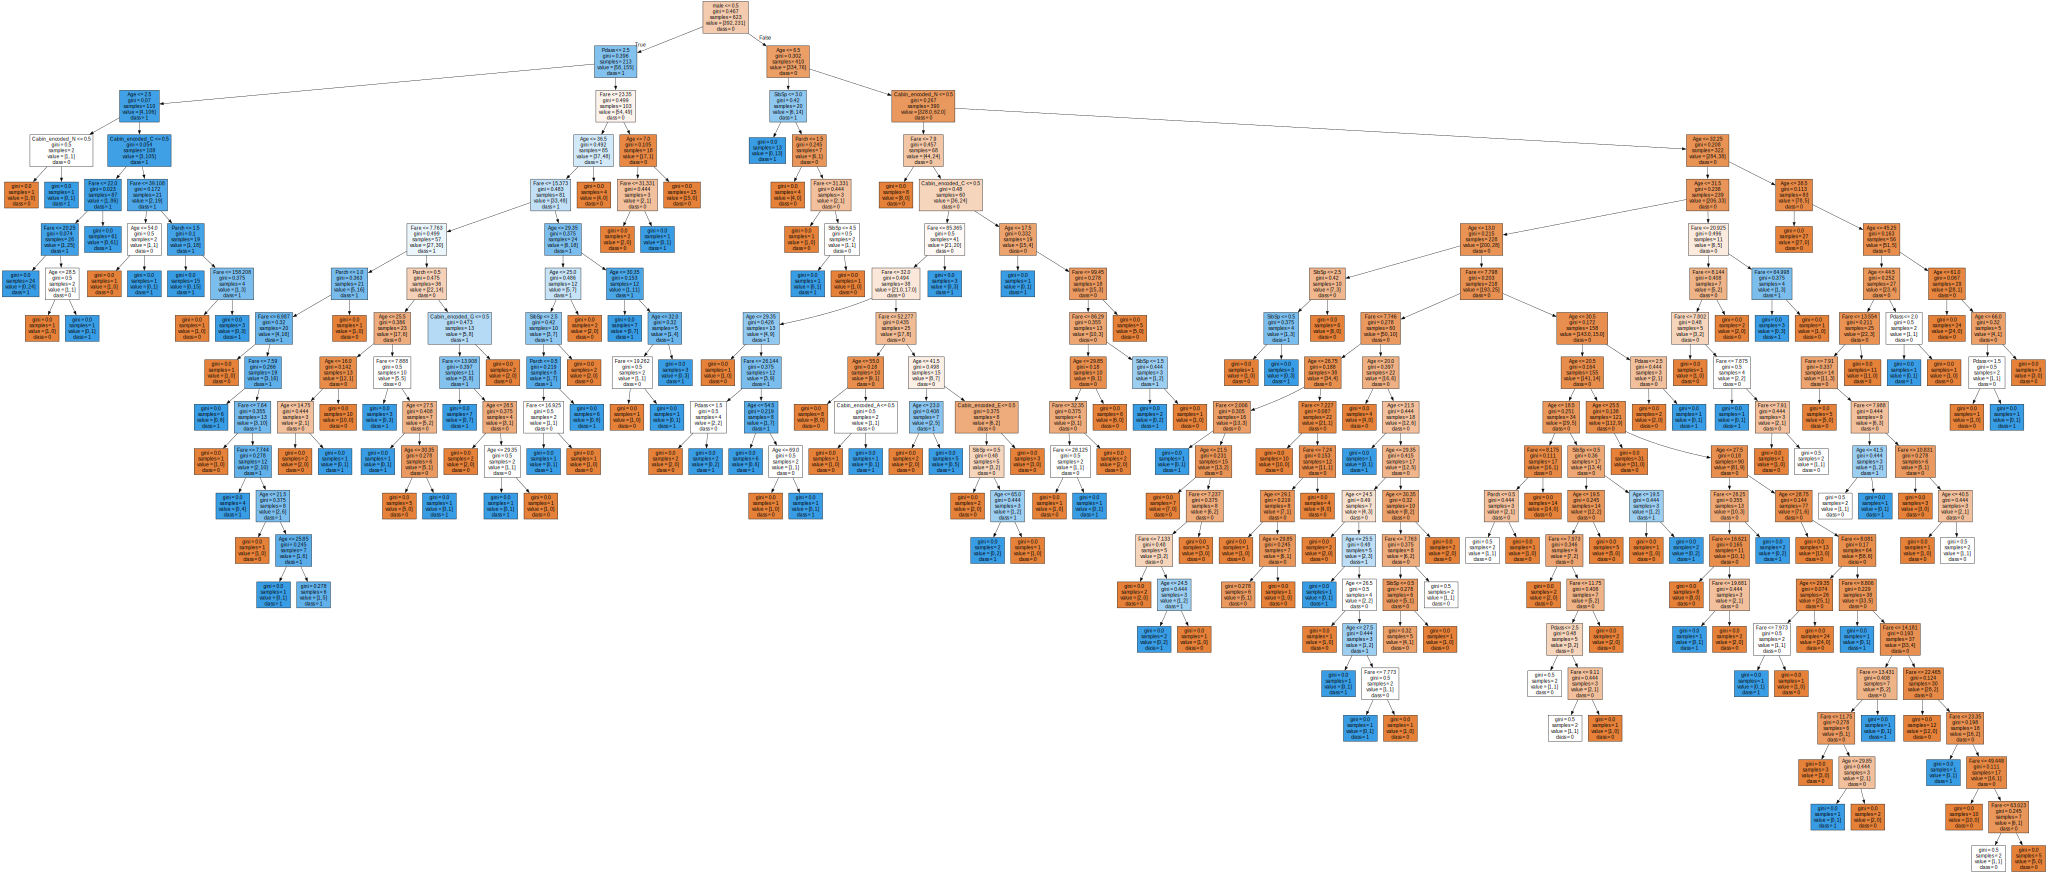

In [8]:
import graphviz

with open("First_Attempt_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


진행해야할 튜닝</br>
max_depth : 2 ~ 20</br>
min_samples_split : 성능 저하로 인해 보류 </br>
min_samples_leaf : 성능 저하로 인해 보류

In [9]:
from sklearn.model_selection import GridSearchCV

parameters = { 'max_depth' : [ i for i in range(2,21)] }

tuned_dct_model = GridSearchCV(dct_model, param_grid = parameters, cv = 3, scoring = 'accuracy', refit = True)
tuned_dct_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=51),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [10]:
result_df = pd.DataFrame(tuned_dct_model.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False).head(10))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.005214,0.007373,0.005398,0.007634,5,{'max_depth': 5},0.807692,0.812500,0.816425,0.812206,0.003571,1
6,0.001338,0.001892,0.005954,0.008420,8,{'max_depth': 8},0.788462,0.788462,0.845411,0.807445,0.026846,2
4,0.005236,0.007405,0.005211,0.007370,6,{'max_depth': 6},0.793269,0.783654,0.840580,0.805834,0.024880,3
8,0.005235,0.007403,0.000000,0.000000,10,{'max_depth': 10},0.778846,0.798077,0.840580,0.805834,0.025793,3
5,0.005211,0.007370,0.005179,0.007324,7,{'max_depth': 7},0.802885,0.783654,0.830918,0.805819,0.019407,5
1,0.005315,0.007517,0.005239,0.007409,3,{'max_depth': 3},0.822115,0.774038,0.821256,0.805803,0.022464,6
7,0.005717,0.004101,0.005036,0.004813,9,{'max_depth': 9},0.788462,0.769231,0.850242,0.802645,0.034560,7
2,0.005389,0.007621,0.005237,0.007407,4,{'max_depth': 4},0.798077,0.793269,0.782609,0.791318,0.006464,8
9,0.005185,0.007333,0.005205,0.007362,11,{'max_depth': 11},0.778846,0.745192,0.845411,0.789816,0.041643,9
12,0.000000,0.000000,0.005224,0.007388,14,{'max_depth': 14},0.764423,0.769231,0.835749,0.789801,0.032549,10


In [11]:
from sklearn.metrics import accuracy_score
best_params_dct = tuned_dct_model.best_estimator_
best_params = tuned_dct_model.best_params_

pred = best_params_dct.predict(X_test)

print("Best hyper parameters : ", best_params)
print("튜닝한 Decision Tree 모델 정확도 : ", accuracy_score(y_test, pred))

Best hyper parameters :  {'max_depth': 5}
튜닝한 Decision Tree 모델 정확도 :  0.8134328358208955


**결과** : 0.7723880597014925 / 0.8134328358208955

**Random Forest**

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

seed_list2 = list()
for i in range(1,101):
    rdf_model = RandomForestClassifier(random_state = i)
    rdf_model.fit(X_train, y_train)
    pred = rdf_model.predict(X_test)
    seed_list2.append(accuracy_score(y_test, pred))

seed = seed_list2.index(max(seed_list2)) + 1

print("가장 좋은 성능을 보여주는 seed : ", seed)

가장 좋은 성능을 보여주는 seed :  15


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rdf_model = RandomForestClassifier(random_state = 15)
rdf_model.fit(X_train, y_train)
pred = rdf_model.predict(X_test)

print("튜닝 안한 Random Forest 모델 정확도 : ", accuracy_score(y_test, pred))

튜닝 안한 Random Forest 모델 정확도 :  0.7985074626865671


In [39]:
from sklearn.model_selection import GridSearchCV

parameters = { 'max_depth' : [ i for i in range(2,21) ]}

tuned_rdf = GridSearchCV(rdf_model, param_grid = parameters, cv = 3, scoring = 'accuracy', refit = True)
tuned_rdf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=15),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [36]:
result_df = pd.DataFrame(tuned_rdf.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False).head(10))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.273099,0.007369,0.015217,0.001205,10,{'max_depth': 10},0.846154,0.788462,0.845411,0.826675,0.027023,1
6,0.267518,0.013885,0.010427,0.007373,8,{'max_depth': 8},0.836538,0.812500,0.830918,0.826652,0.010267,2
12,0.273827,0.007240,0.015650,0.000032,14,{'max_depth': 14},0.822115,0.793269,0.855072,0.823486,0.025250,3
7,0.278823,0.019889,0.015757,0.000185,9,{'max_depth': 9},0.831731,0.802885,0.835749,0.823455,0.014637,4
11,0.272018,0.005354,0.010443,0.007385,13,{'max_depth': 13},0.817308,0.798077,0.850242,0.821875,0.021540,5
9,0.274316,0.007555,0.010451,0.007390,11,{'max_depth': 11},0.836538,0.769231,0.855072,0.820281,0.036882,6
10,0.278793,0.006094,0.010715,0.007576,12,{'max_depth': 12},0.826923,0.793269,0.835749,0.818647,0.018303,7
16,0.276204,0.006070,0.013292,0.003374,18,{'max_depth': 18},0.802885,0.793269,0.850242,0.815465,0.024902,8
17,0.278831,0.007775,0.010673,0.007547,19,{'max_depth': 19},0.802885,0.798077,0.845411,0.815457,0.021271,9
14,0.275038,0.006673,0.015782,0.000224,16,{'max_depth': 16},0.807692,0.802885,0.835749,0.815442,0.014493,10


In [37]:
from sklearn.metrics import accuracy_score
best_params_dct = tuned_rdf.best_estimator_
best_params = tuned_rdf.best_params_

pred = best_params_dct.predict(X_test)

print("Best hyper parameters : ", best_params)
print("튜닝한 Random Forest 모델 정확도 : ", accuracy_score(y_test, pred))

Best hyper parameters :  {'max_depth': 10}
튜닝한 Random Forest 모델 정확도 :  0.8097014925373134


**결과** : 0.79850746268656710 / 0.8097014925373134

**XGBoost**

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

seed_list3 = list()

for i in range(1,31):
    xgb_model = XGBClassifier(random_state = i)
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict(X_test)
    seed_list3.append(accuracy_score(y_test, pred))

seed = seed_list3.index(max(seed_list3)) + 1

print("가장 좋은 성능을 보여주는 seed : ", seed)

가장 좋은 성능을 보여주는 seed :  1


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

xgb_model = XGBClassifier(n_estimators = 400, early_stopping_rounds = 50, eval_metric = 'logloss', random_state = 1)
xgb_model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)] , verbose = True)
pred = xgb_model.predict(X_test)

print("튜닝 안한 XGB 모델 정확도 : ", accuracy_score(y_test, pred))

[0]	validation_0-logloss:0.50790
[1]	validation_0-logloss:0.45152
[2]	validation_0-logloss:0.40331
[3]	validation_0-logloss:0.37315
[4]	validation_0-logloss:0.35669
[5]	validation_0-logloss:0.34341
[6]	validation_0-logloss:0.33850
[7]	validation_0-logloss:0.34051
[8]	validation_0-logloss:0.34181
[9]	validation_0-logloss:0.34301
[10]	validation_0-logloss:0.33989
[11]	validation_0-logloss:0.34602
[12]	validation_0-logloss:0.34544
[13]	validation_0-logloss:0.33854
[14]	validation_0-logloss:0.34994
[15]	validation_0-logloss:0.34169
[16]	validation_0-logloss:0.34576
[17]	validation_0-logloss:0.34469
[18]	validation_0-logloss:0.33957
[19]	validation_0-logloss:0.34075
[20]	validation_0-logloss:0.34065
[21]	validation_0-logloss:0.34289
[22]	validation_0-logloss:0.34534
[23]	validation_0-logloss:0.34983
[24]	validation_0-logloss:0.35411
[25]	validation_0-logloss:0.35719
[26]	validation_0-logloss:0.35959
[27]	validation_0-logloss:0.36572
[28]	validation_0-logloss:0.37000
[29]	validation_0-loglos

In [9]:
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.2, 0.8),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
                    'colsample_bytree' : hp.uniform('colsample_bytree',0.5, 1)}  



In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def objective_func(search_space):
    xgb_model = XGBClassifier(n_estimators = 400, early_stopping_rounds = 50, eval_metric = 'logloss', random_state = 1,
                              max_depth = int(search_space['max_depth']),
                              learning_rate = search_space['learning_rate'],
                              min_child_weight = int(search_space['min_child_weight']),
                              colsample_bytree = search_space['colsample_bytree'])

    accuracy_list = list()

    kf = KFold(n_splits = 3)
    
    for train_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[train_index], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        xgb_model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)])
        pred = xgb_model.predict(X_val)
        accuracy_list.append(accuracy_score(y_val, pred))

    return {'loss' : -1 * np.mean(accuracy_list), 'status' : STATUS_OK}

In [11]:
trials = Trials()

#best_params = fmin(fn = objective_func, space = xgb_search_space, algo = tpe.suggest, max_evals = 50, trials = trials)

{'colsample_bytree': 0.7088371213823975, 'learning_rate': 0.6685051376363278, 'max_depth': 16.0, 'min_child_weight': 4.0}</br>
\# Google Colab 결과

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

xgb_model = XGBClassifier(n_estimators = 400, early_stopping_rounds = 50, eval_metric = 'logloss', random_state = 1,
                          learning_rate = 0.6685051376363278, max_depth = 16, 
                          min_child_weight = 4, colsample_bytree = 0.7088371213823975)
                         
xgb_model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)] , verbose = True)
pred = xgb_model.predict(X_test)

print("튜닝한 XGB 모델 정확도 : ", accuracy_score(y_test, pred))

[0]	validation_0-logloss:0.43133
[1]	validation_0-logloss:0.38020
[2]	validation_0-logloss:0.35481
[3]	validation_0-logloss:0.34982
[4]	validation_0-logloss:0.34026
[5]	validation_0-logloss:0.32712
[6]	validation_0-logloss:0.32920
[7]	validation_0-logloss:0.31834
[8]	validation_0-logloss:0.32386
[9]	validation_0-logloss:0.32981
[10]	validation_0-logloss:0.33024
[11]	validation_0-logloss:0.33201
[12]	validation_0-logloss:0.32869
[13]	validation_0-logloss:0.32451
[14]	validation_0-logloss:0.31766
[15]	validation_0-logloss:0.31608
[16]	validation_0-logloss:0.31164
[17]	validation_0-logloss:0.32327
[18]	validation_0-logloss:0.32624
[19]	validation_0-logloss:0.31599
[20]	validation_0-logloss:0.31767
[21]	validation_0-logloss:0.32058
[22]	validation_0-logloss:0.30682
[23]	validation_0-logloss:0.30744
[24]	validation_0-logloss:0.30223
[25]	validation_0-logloss:0.29922
[26]	validation_0-logloss:0.30193
[27]	validation_0-logloss:0.30958
[28]	validation_0-logloss:0.30767
[29]	validation_0-loglos

**결과** : 0.8097014925373134 / 0.8208955223880597

**LightGBM**

In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

seed_list4 = list()
for i in range(1,101):
    lgb_model = LGBMClassifier(random_state = i)
    lgb_model.fit(X_train, y_train)
    pred = lgb_model.predict(X_test)
    seed_list4.append(accuracy_score(y_test, pred))

seed = seed_list4.index(max(seed_list4)) + 1

print("가장 좋은 성능을 보여주는 seed : ", seed) 

가장 좋은 성능을 보여주는 seed :  1


In [52]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

lgb_model = LGBMClassifier(n_estimators = 400, early_stopping_round = 50, eval_metric = 'logloss', random_state = 1)
lgb_model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)])
pred = lgb_model.predict(X_test)

print("튜닝 전 LGBM 모델 정확도 : ", accuracy_score(y_test, pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[1]	valid_0's binary_logloss: 0.60159
[2]	valid_0's binary_logloss: 0.561067
[3]	valid_0's binary_logloss: 0.528837
[4]	valid_0's binary_logloss: 0.500161
[5]	valid_0's binary_logloss: 0.477962
[6]	valid_0's binary_logloss: 0.458395
[7]	valid_0's binary_logloss: 0.440484
[8]	valid_0's binary_logloss: 0.424917
[9]	valid_0's binary_logloss: 0.412777
[10]	valid_0's binary_logloss: 0.402946
[11]	valid_0's binary_logloss: 0.391513
[12]	valid_0's binary_logloss: 0.380226
[13]	valid_0's binary_logloss: 0.370982
[14]	valid_0's binary_logloss: 0.364239
[15]	valid_0's binary_logloss: 0.358183
[16]	valid_0's binary_logloss: 0.353349
[17]	valid_0's binary_logloss: 0.349362
[18]	valid_0's binary_logloss: 0.345563
[19]	valid_0's binary_logloss: 0.342761
[20]	valid_0's binary_logloss: 0.339014
[21]	valid_0's binary_logloss: 0.336377
[22]	valid_0's binary_logloss: 0.333671
[23]	valid_0's binary_logloss: 0.330808
[24]	valid_0's binary_logloss: 0.32486

In [40]:
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves',20, 40, 1), 'max_depth' : hp.quniform('max_depth', 5, 15, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 10, 20, 1), 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)}

In [41]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

def objective_func(search_space):
    lgb_model = LGBMClassifier(n_estimators = 400, early_stopping_round = 50, random_state = 1,
                               num_leaves = int(search_space['num_leaves']), max_depth = int(search_space['max_depth']),
                               min_child_samples = int(search_space['min_child_samples']), colsample_bytree = search_space['colsample_bytree'])

    accuracy_list = list()
    kf = KFold(n_splits = 3)

    for train_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[train_index], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        lgb_model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)], eval_metric = 'logloss',)
        pred = lgb_model.predict(X_val)

        accuracy_list.append(accuracy_score(y_val, pred))

    return {'loss' : -1 * np.mean(accuracy_list), 'status' : STATUS_OK}

In [45]:
trials = Trials()

#best_param = fmin(fn = objective_func, space = lgbm_search_space, algo = tpe.suggest, max_evals = 50, trials = trials)

In [50]:
#best_param = {'colsample_bytree': 0.9442348152939775, 'max_depth': 9.0, 'min_child_samples': 19.0, 'num_leaves': 37.0}
best_param = {'colsample_bytree': 0.7701703686707142, 'learning_rate': 0.24991720171262022, 'max_depth': 11.0, 'num_leaves': 34.0}
# google colab 학습 결과

In [51]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgb_model = LGBMClassifier(n_estimators = 400, early_stopping_round = 50, random_state = 1,
                               num_leaves = int(best_param['num_leaves']), max_depth = int(best_param['max_depth']),
                               learning_rate = best_param['learning_rate'], colsample_bytree = best_param['colsample_bytree'])

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

lgb_model.fit(X_train, y_train, eval_set = [(X_val,y_val)], eval_metric = 'logloss')
pred = lgb_model.predict(X_test)

print("튜닝 후 LGBM 모델 정확도 : ", accuracy_score(y_test, pred))

[1]	valid_0's binary_logloss: 0.520108
[2]	valid_0's binary_logloss: 0.442665
[3]	valid_0's binary_logloss: 0.396921
[4]	valid_0's binary_logloss: 0.363859
[5]	valid_0's binary_logloss: 0.332511
[6]	valid_0's binary_logloss: 0.30445
[7]	valid_0's binary_logloss: 0.29619
[8]	valid_0's binary_logloss: 0.278185
[9]	valid_0's binary_logloss: 0.268104
[10]	valid_0's binary_logloss: 0.259787
[11]	valid_0's binary_logloss: 0.254601
[12]	valid_0's binary_logloss: 0.246331
[13]	valid_0's binary_logloss: 0.238879
[14]	valid_0's binary_logloss: 0.232706
[15]	valid_0's binary_logloss: 0.22184
[16]	valid_0's binary_logloss: 0.216491
[17]	valid_0's binary_logloss: 0.214833
[18]	valid_0's binary_logloss: 0.204346
[19]	valid_0's binary_logloss: 0.199425
[20]	valid_0's binary_logloss: 0.193968
[21]	valid_0's binary_logloss: 0.193733
[22]	valid_0's binary_logloss: 0.194263
[23]	valid_0's binary_logloss: 0.19
[24]	valid_0's binary_logloss: 0.189702
[25]	valid_0's binary_logloss: 0.181664
[26]	valid_0's b